# Dr LIM - Dimensionality reduction by Learning Invariant Mapping

- This paper (similar to TSNE) proposes an alternative method to achieve dimensionality reduction

In [1]:
from functools import reduce
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from image_utilities import plot_images

## CNN used in the paper 

![CNN architecture](./images/cnn.png)

### Torch implementation 

#### Forward

In [44]:
class DrlimCNN(nn.Module):
    def __init__(self):
        super(DrlimCNN, self).__init__()
        
        # Layer 1:
        # n_input_channel = 1
        # n_output_channel = 15
        # Kernel Size = 8 for padding = 0, stride = 1
        k_size = 6
        in_channels = 1
        out_channels = 15 
        self.layer_1 = nn.Conv2d(in_channels, out_channels, k_size)
        
        # Layer 2: Subsampling - Maxpooling
        # Kernel Size = 19  for padding=0 and stride = 1
        k_size = 19
        self.max_pooling = nn.MaxPool2d(k_size, stride=1)
        
        # Layer 3: Conv layer
        # n_input_channel = 15
        # n_output_channel = 30
        # Kernel size = 9
        in_channels = 15
        out_channels = 30
        k_size = 9
        self.layer_3 = nn.Conv2d(in_channels, out_channels, k_size)
        
        # Layer 4: Fully connected
        self.output_layer = nn.Linear(30, 2)
        
        # Output probs
        self.softmax = nn.Softmax(dim=1)
        
        # Relu
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Add relu on top of conv layer
        x = self.layer_1(x)
        x = self.relu(x)
        
        # Maxpool 
        x = self.max_pooling(x)
        
        # Another conv
        x = self.layer_3(x)
        
        # Get the size except for batch
        print("Shae")
        print(x.shape)
        num_flat_features = reduce(lambda x, y: x * y, x.shape[1:])
        print(num_flat_features)
        
        # Flatten
        x = x.reshape(1, num_flat_features)
        
        # Fully connected 
        x = self.output_layer(x)
        #x = self.softmax(x)
        
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = DrlimCNN()

# Enable GPU
net.to(device)
net.cuda()

cuda:0


DrlimCNN(
  (layer_1): Conv2d(1, 15, kernel_size=(6, 6), stride=(1, 1))
  (max_pooling): MaxPool2d(kernel_size=19, stride=1, padding=0, dilation=1, ceil_mode=False)
  (layer_3): Conv2d(15, 30, kernel_size=(9, 9), stride=(1, 1))
  (output_layer): Linear(in_features=30, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
)

#### Backward

##### Define contrastive loss function

In [45]:
def contrastive_loss(output_1, output_2, 
            target_1, target_2):
    if target_1 == target_2:
        y = torch.zeros_like(output_1, requires_grad=True)
    else:
        y = torch.ones_like(output_1, requires_grad=True)
        
    distance = torch.norm(output_1 - output_2)
    ls = torch.pow(distance, 2)
    ld = torch.max(torch.zeros_like(output_1), distance)
    ld = torch.pow(ld, 2)
    
    loss = torch.mean((1 - y) * ls + y * ld)
    
    return loss

In [53]:
# Test Code
input_1 = torch.randn(1, 1, 32, 32)
input_2 = torch.randn(1, 1, 32, 32)

out_1 = net(input_1.cuda())
out_2 = net(input_2.cuda())
out_1 = out_1.requires_grad_(True)
out_2 = out_2.requires_grad_(True)

print("---------")
print(out_1.requires_grad)
print(out_2.requires_grad)
print("---------")

print("Before:")
print(net.output_layer.weight.grad)
loss = contrastive_loss(out_1, out_2,
                        0, 0)
print(loss)
loss.backward()
print("After:")
print(net.output_layer.weight.grad)

Shae
torch.Size([1, 30, 1, 1])
30
Shae
torch.Size([1, 30, 1, 1])
30
---------
True
True
---------
Before:
tensor([[-0.1469,  0.0284,  0.2501, -0.0105,  0.0645,  0.0915,  0.0288,  0.0407,
         -0.0199, -0.0312, -0.0059,  0.0477, -0.1238,  0.0492,  0.1262,  0.0412,
          0.0138,  0.0353, -0.0981, -0.1528, -0.0737,  0.0602, -0.0382,  0.0836,
         -0.0363, -0.0408, -0.0181,  0.1253, -0.1095,  0.0084],
        [ 0.3018, -0.1719, -0.2395,  0.0209,  0.1684, -0.0542, -0.3459,  0.0203,
         -0.0885, -0.1709, -0.0121,  0.0994,  0.0604, -0.1789, -0.4296,  0.1218,
         -0.1222, -0.0336,  0.3747,  0.1550,  0.3225, -0.1560, -0.0822, -0.1489,
          0.0669,  0.0868,  0.1212, -0.1626,  0.0383,  0.1046]],
       device='cuda:0')
tensor(0.1024, device='cuda:0', grad_fn=<MeanBackward0>)
After:
tensor([[-0.0834,  0.0499,  0.2483,  0.1104,  0.0903,  0.1733, -0.0372,  0.0161,
          0.0989, -0.0394,  0.0677,  0.0210, -0.1638,  0.0088,  0.1032, -0.1617,
          0.0355,  0.2589, -0

## Load Data

In [5]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

## Train

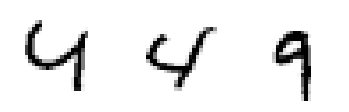

In [6]:
for batch_idx, (data, target) in enumerate(train_loader):
    # Choose only either 5 or 10 number 
    filter_index = ((target == 4) | (target == 9))
    data = data[filter_index]
    target = target[filter_index]
    
    if batch_idx == 0:
        temp = data.numpy()
        temp = temp[0:10, ...]
        temp = temp.squeeze()
        plot_images(temp)